## 简单 MoE ##
Input -> FFN1 ... FFNn -> Gate -> Out \
FFN —— 专家网络 (Linear)(互相独立) \
Gate —— 门控网络 (Linear)
$$\begin{aligned}
Err(x) &= \sum_{i=1}^n p_i(x) \cdot ||Target - FFN_i(x)|| \\
     &= \sum_{i=1}^n p_i(x) \cdot Err_i(x)
\end{aligned}$$
策略为：有着小 Erri(x) 的专家 i 会有更大的概率 pi(x) 被选择  \
最终的 Err(x) 就会倾向于专家 i \

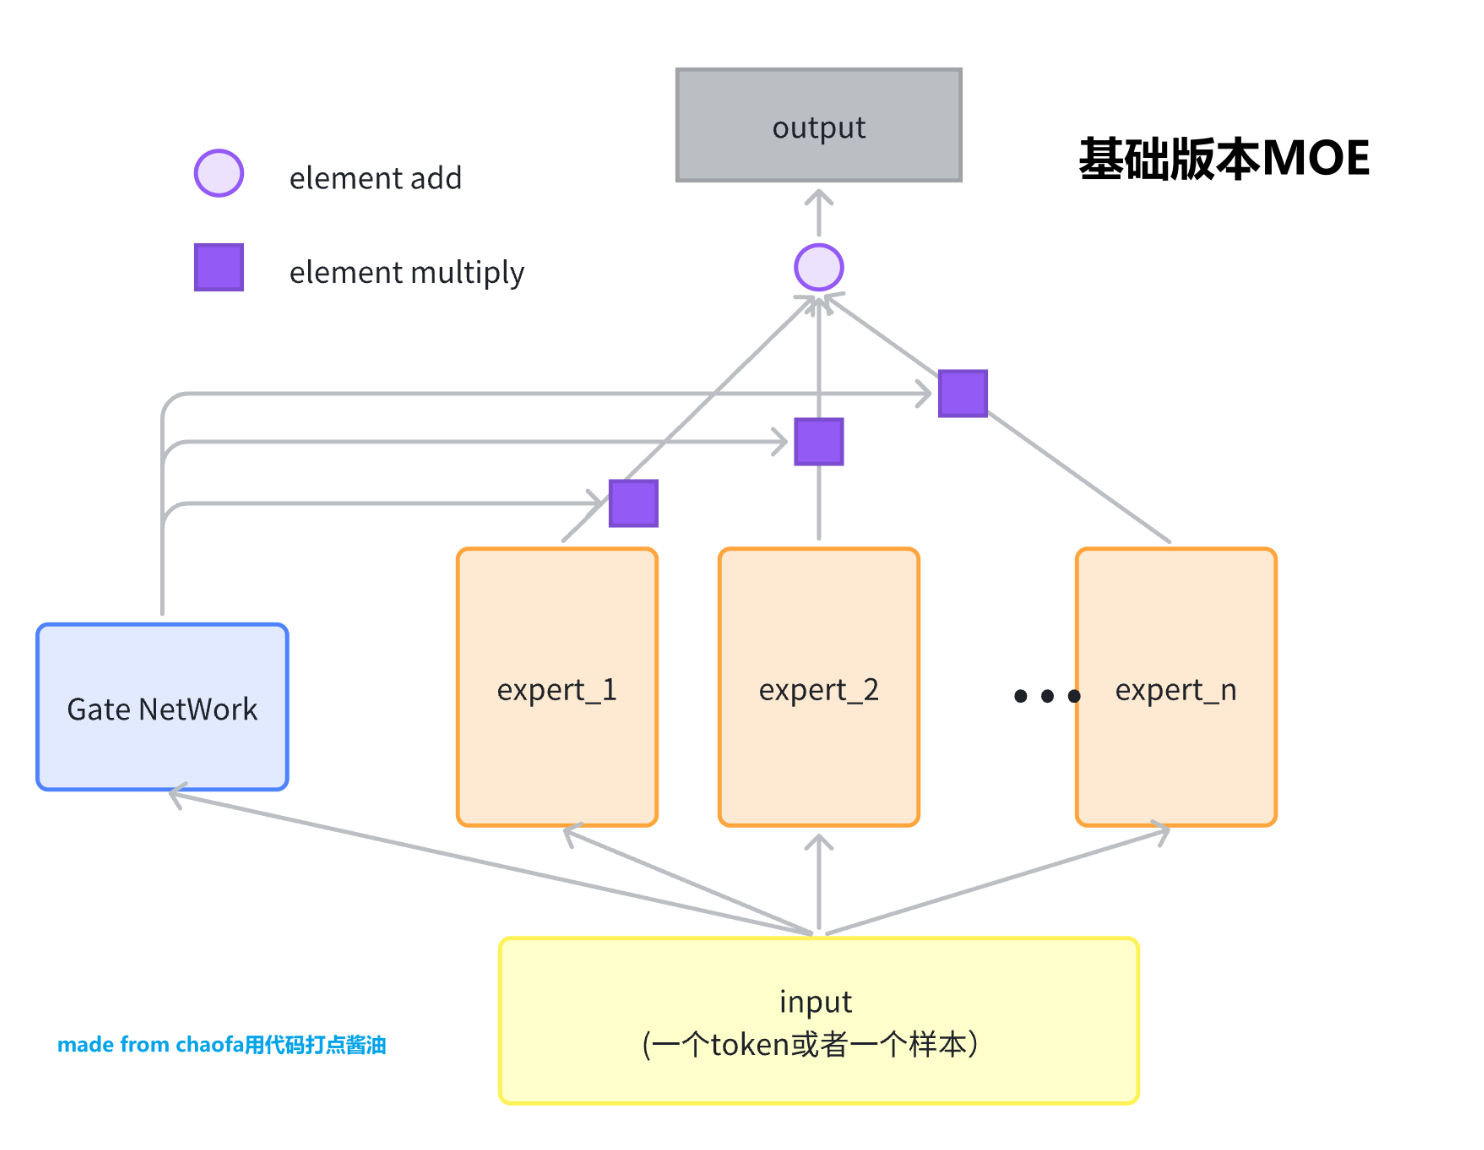

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleExpert(nn.Module):
    def __init__(self, input_dim, output_dim, bias=True):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim, bias=bias)
    
    def forward(self, x):
        output = self.fc(x)
        return output


class MoELayer(nn.Module):
    def __init__(self, num_experts, input_dim, output_dim, bias=True):
        super(MoELayer, self).__init__()
        self.num_experts = num_experts
        self.exports = nn.ModuleList(
            [
                SimpleExpert(input_dim, output_dim, bias=bias) for _ in range(num_experts)
            ]
        )
        self.gate = nn.Linear(input_dim, num_experts, bias=False)
    
    def forward(self, x):
        # x.shape:
        # bs, input_dim

        # 门控输出每个专家的选择权重
        # bs, 1, num_experts
        gate_score = F.softmax(self.gate(x), dim=-1).unsqueeze(1)

        # 将每个专家的结果堆到一起, 直接 torch.stack, 或提前升维后再 torch.concat
        # bs, num_experts, output_dim
        expert_outputs = torch.stack(
            [
                expert(x) for expert in self.exports
            ],
            dim=1
        )

        # torch.bmm 或 @ 消除维度
        output = torch.bmm(gate_score, expert_outputs)
        return output.squeeze(1) # bs, hidden_dim

input_dim = 32
output_dim = 16
num_experts = 3
batch_size = 4

model = MoELayer(num_experts, input_dim, output_dim)
print(model)
demo = torch.randn(batch_size, input_dim)
output = model(demo)
print(output.shape)



### 替换 MLP ###
使用 MoELayer 替换掉 MLP 中的所有隐藏层

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_experts):
        super(MLP, self).__init__()
        self.fc1 = MoELayer(num_experts, input_size, hidden_size)
        self.fc2 = MoELayer(num_experts, hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 测试用例
input_size = 10
hidden_size = 20
output_size = 5
num_experts = 3

x = torch.randn(1, input_size)

model = MLP(input_size, hidden_size, output_size, num_experts)
print(model)
output = model(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

## Sparse MoE ##
选择 top_k 个专家 \
再对这 top_k 个专家的输出进行加权求和 \
输入 Shape=(batch, seq_len, hidden_dim)

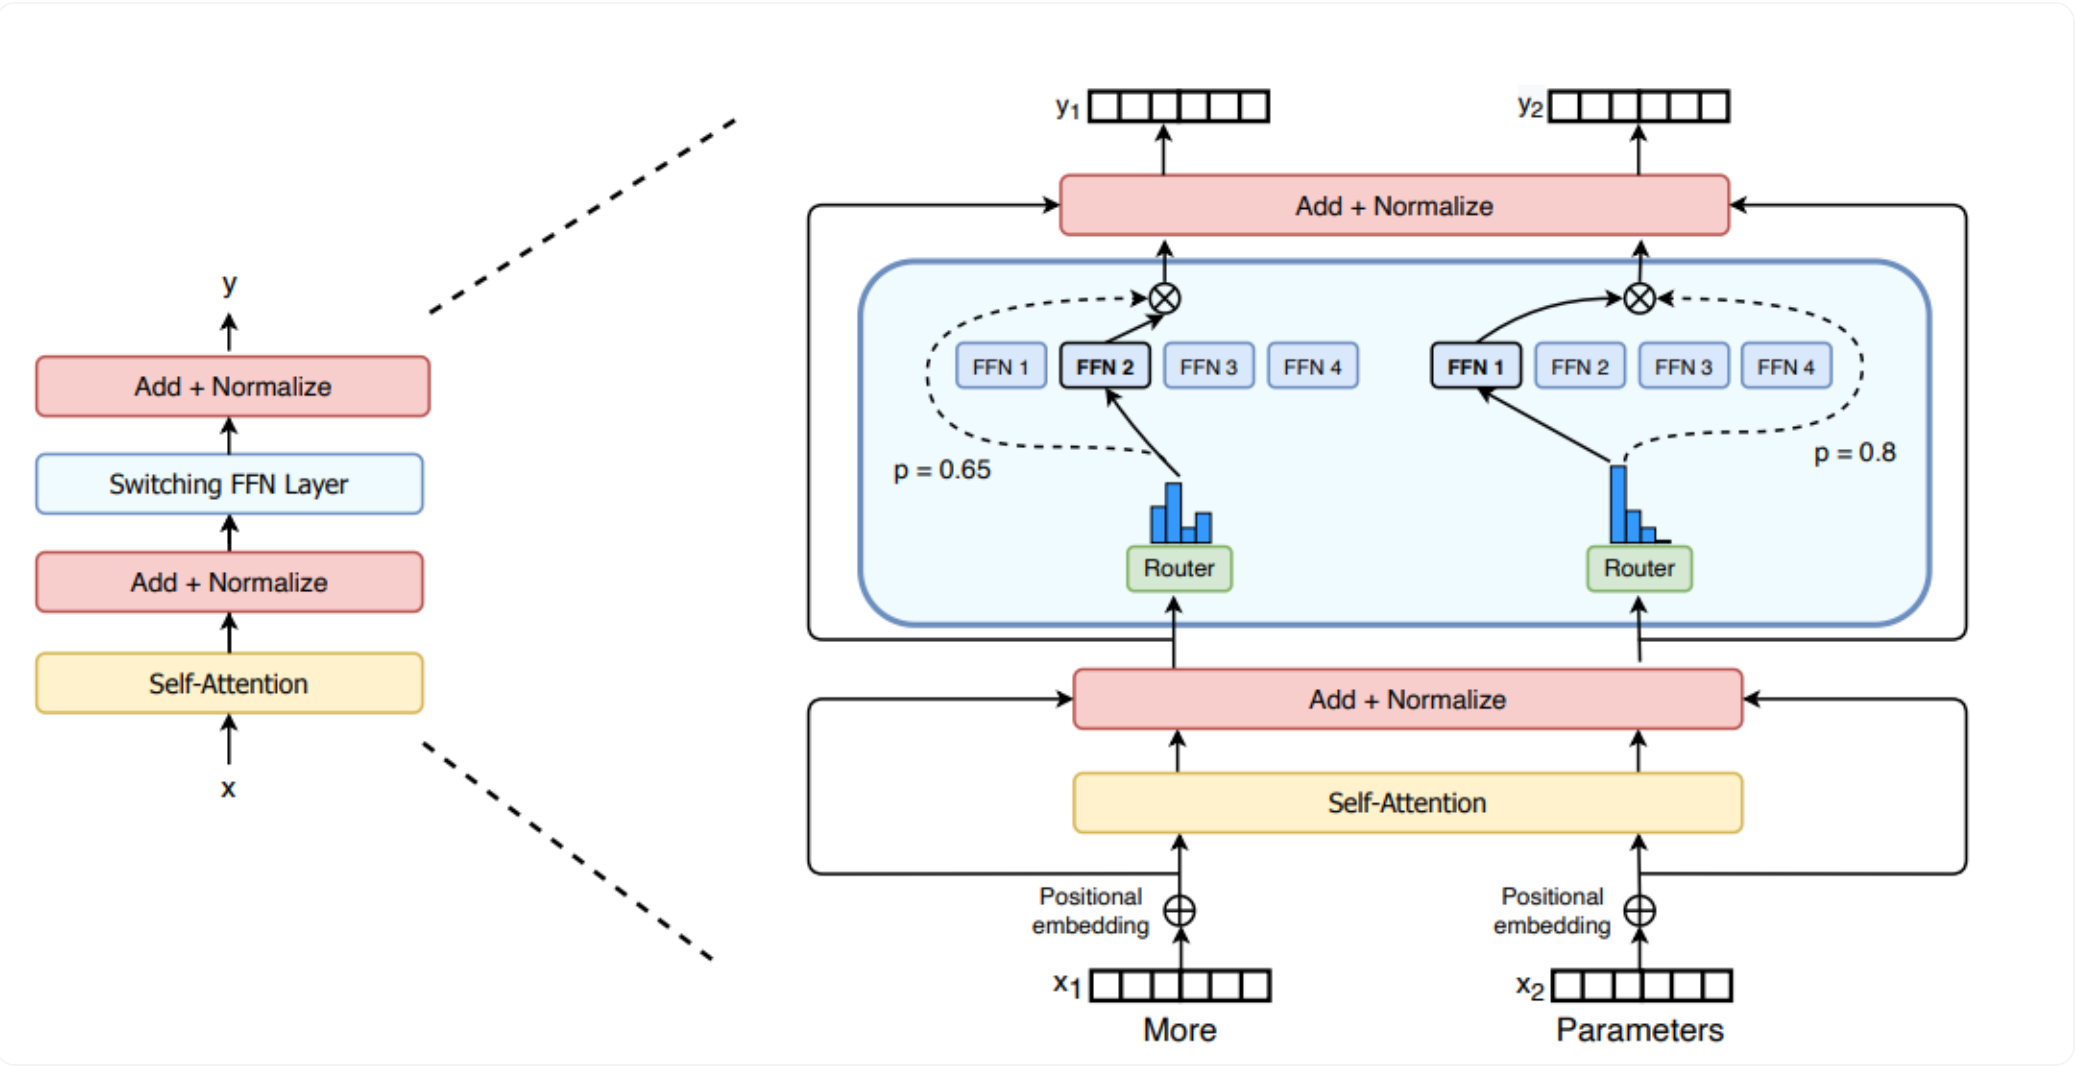

In [ ]:
class MoEConfig:
    def __init__(self, num_experts, hidden_dim, top_k, num_shared_experts=2):
        self.num_experts = num_experts
        self.hidden_dim = hidden_dim
        self.top_k = top_k
        self.num_shared_experts = num_shared_experts


class MoERouter(nn.Module):
    # gate
    def __init__(self, config: MoEConfig):
        super().__init__()
        self.gate = nn.Linear(config.hidden_dim, config.num_experts)

        self.num_experts = config.num_experts
        self.top_k = config.top_k

    def forward(self, x):
        # (bs * seq, hidden_dim)

        # 每个专家的选择概率
        router_logits = self.gate(x) # (bs*seq, num_experts)
        router_probs = F.softmax(router_logits, dim=-1, dtype=torch.float16) # (bs*seq, num_experts)

        router_weights, selected_experts_indices = torch.topk(
            router_probs, 
            k=self.top_k, 
            dim=-1,
        ) # (bs*seq, top_k)
        # 对每个 token 选择最大概率的 top_k 个专家 ( torch.topk 可以反向传播)
        # weights: 最大的 top_k 个概率, 如4专家中 [0.1, 0.2, 0.4, 0.3] -> [0.4, 0.3]
        # indices: 对应的专家的索引,    如4专家中 [0.1, 0.2, 0.4, 0.3] -> [2, 3]


        # 重新归一化
        router_weights = router_weights / router_weights.sum(
            dim=-1, keepdim=True
        )
        router_weights = router_weights.to(x.dtype) # 原来数据类型

        expert_mask = F.one_hot(
            selected_experts_indices,
            num_classes=self.num_experts
        ) # (bs*seq, top_k, num_experts)
        # 生成专家掩码
        # F.one_hot 每个被选择的专家索引 用向量表示 
        # 比如某 token(1,) 选择 [1, 3] 专家, 则对应 mask 就是 [[1, 0, 0, ..], [0, 0, 1, ...]]

        expert_mask = expert_mask.permute(-1, 1, 0) # (num_experts, top_k, bs*seq)
        # 将第 0 维变为专家的维度, 便于后续计算
        # [ 
        #   [[0, 1, 0, ..], ---- expert 1 作为 top 1 被 token 2 选中
        #    [0, 0, 0, ..]],     作为 top 2 没有被选中
        #
        #   [[1, 0, 0, ..], ---- expert 2 作为 top 1 被 token 1 选中
        #    [0, 0, 1, ..]],     作为 top 2 被 token 3 选中
        #
        #   ...
        # ]

        return router_logits, router_weights, selected_experts_indices, expert_mask


class SparseMoE(nn.Module):
    def __init__(self, config: MoEConfig):
        super().__init__()
        self.config = config
        self.top_k = config.top_k
        self.hidden_dim = config.hidden_dim
        self.num_experts = config.num_experts
        self.experts = nn.ModuleList(
            [
                SimpleExpert(config.hidden_dim, config.hidden_dim) for _ in range(config.num_experts)
            ]
        )
        # 门控
        self.router = MoERouter(config)
    
    def forward(self, x):
        
        bs, seq, hidden_dim = x.size()

        hidden_states = x.view(-1, hidden_dim) # bs * seq, hidden_dim
        # 对 token 维度计算, 需要 reshape

        router_logits, router_weights, selected_experts_indices, expert_mask = self.router(hidden_states)
        # gate_logits, gate_scores
        # (bs*seq, num_experts), (bs*seq, top_k), (bs*seq, top_k), (num_experts, top_k, bs*seq)
        # 每个 seq 的 x 都对应选择的一个专家

        final_hidden_states = torch.zeros_like(x)
        # 提前初始化, 避免多次内存分配

        for expert_idx, expert in enumerate(self.num_experts):

            top_x, token_x = torch.where(expert_mask[expert_idx]) # (num_selected_tokens,)
            # token_x 为选择了该 expert 的 token 索引
            # top_x 为 token_x 对应 token 是该 expert的 top 等级 (0 最大概率, 1, 2, ...)
            # 若对 expert 0 有: top_x=[0, 1, 1], token_x=[4, 0, 2] 则:
            # token 4 是 expert 0 的 t0
            # token 0 是 expert 0 的 t1
            # token 2 是 expert 0 的 t1

            current_state = hidden_states.unsqueeze(0)[:, token_x, :].reshape(-1, hidden_dim) # (num_selected_tokens, hidden_dim)
            # 取出 token_x 位置的所有隐藏状态

            current_hidden_state = expert(current_state) * router_weights[token_x, top_x].unsqueeze(-1)
            # (num_selected_tokens, hidden_dim) * (num_selected_tokens, 1)
            # 从 router_weights 中"逐元素"选出该 expert 所有 selected_tokens 对应的权重 (num_selected_tokens,)
            # unsqueeze(-1)操作升维 -> (num_selected_tokens, 1)
            # 这些权重会与 expert 输出的 hidden_state 逐个点乘

            final_hidden_states.index_add_(0, token_x, current_hidden_state.to(hidden_states.dtype)) # (num_selected_tokens, hidden_dim)
            # 性能更好的逐元素加法, +=需要多次读写, index_add_只需一次读写
        
        final_hidden_states = final_hidden_states.reshape(bs, seq, hidden_dim) # 还原 shape

        return final_hidden_states, router_logits



bs, seq, hidden_dim, num_experts = 2, 4, 16, 3
x = torch.rand(bs, seq, hidden_dim)
# 输出就应该是 (bs, seq, hidden_dim) 和 (bs*seq, num_experts)

config = MoEConfig(hidden_dim=hidden_dim, num_experts=num_experts, top_k=2)
token_level_MoE = SparseMoE(config)
output = token_level_MoE(x)

print(output[0].shape, output[1].shape)


#### 补充 TopK 反向传播 ####
torch.topk() 是 PyTorch 中用于获取张量的前 k 大值及其索引的方法，但它的梯度传播方式与一般算子不同。\
由于 topk 是一个离散操作，直接对它的输出进行梯度计算是不可导的，\
所以 PyTorch 在计算反向传播时采用了一种**梯度直通(straight-through estimator, STE)** 的方式。

\
topk 操作涉及索引选择，它在数学上不可微: 
- 对于选中的元素，它们的梯度应当保持不变（从下游传播）。\
- 对于未选中的元素，它们的梯度应当为零（因为它们对 topk 结果没有贡献）。

\
PyTorch 采用**掩码（masking）**的方式处理: 
1. 构造梯度掩码：在 **topk 选中的索引位置赋值 1，其他位置赋值 0**。
2. 将下游梯度传递给 topk 选中的元素。
3. **其他元素梯度为 0**，不会影响梯度计算。
$$
\frac{\partial \text{ topk}(x)}{\partial x_i} =
\begin{cases}
1, & i \in \text{topk} \\
0, & \text{otherwise}
\end{cases}
$$

## ShareExpert Sparse MoE ##
共享 expert 的 MoE 网络 \
变化: \
所有 token 都会经过一个共享的 shared experts. \
与原来的 topK 专家结果加权输出.

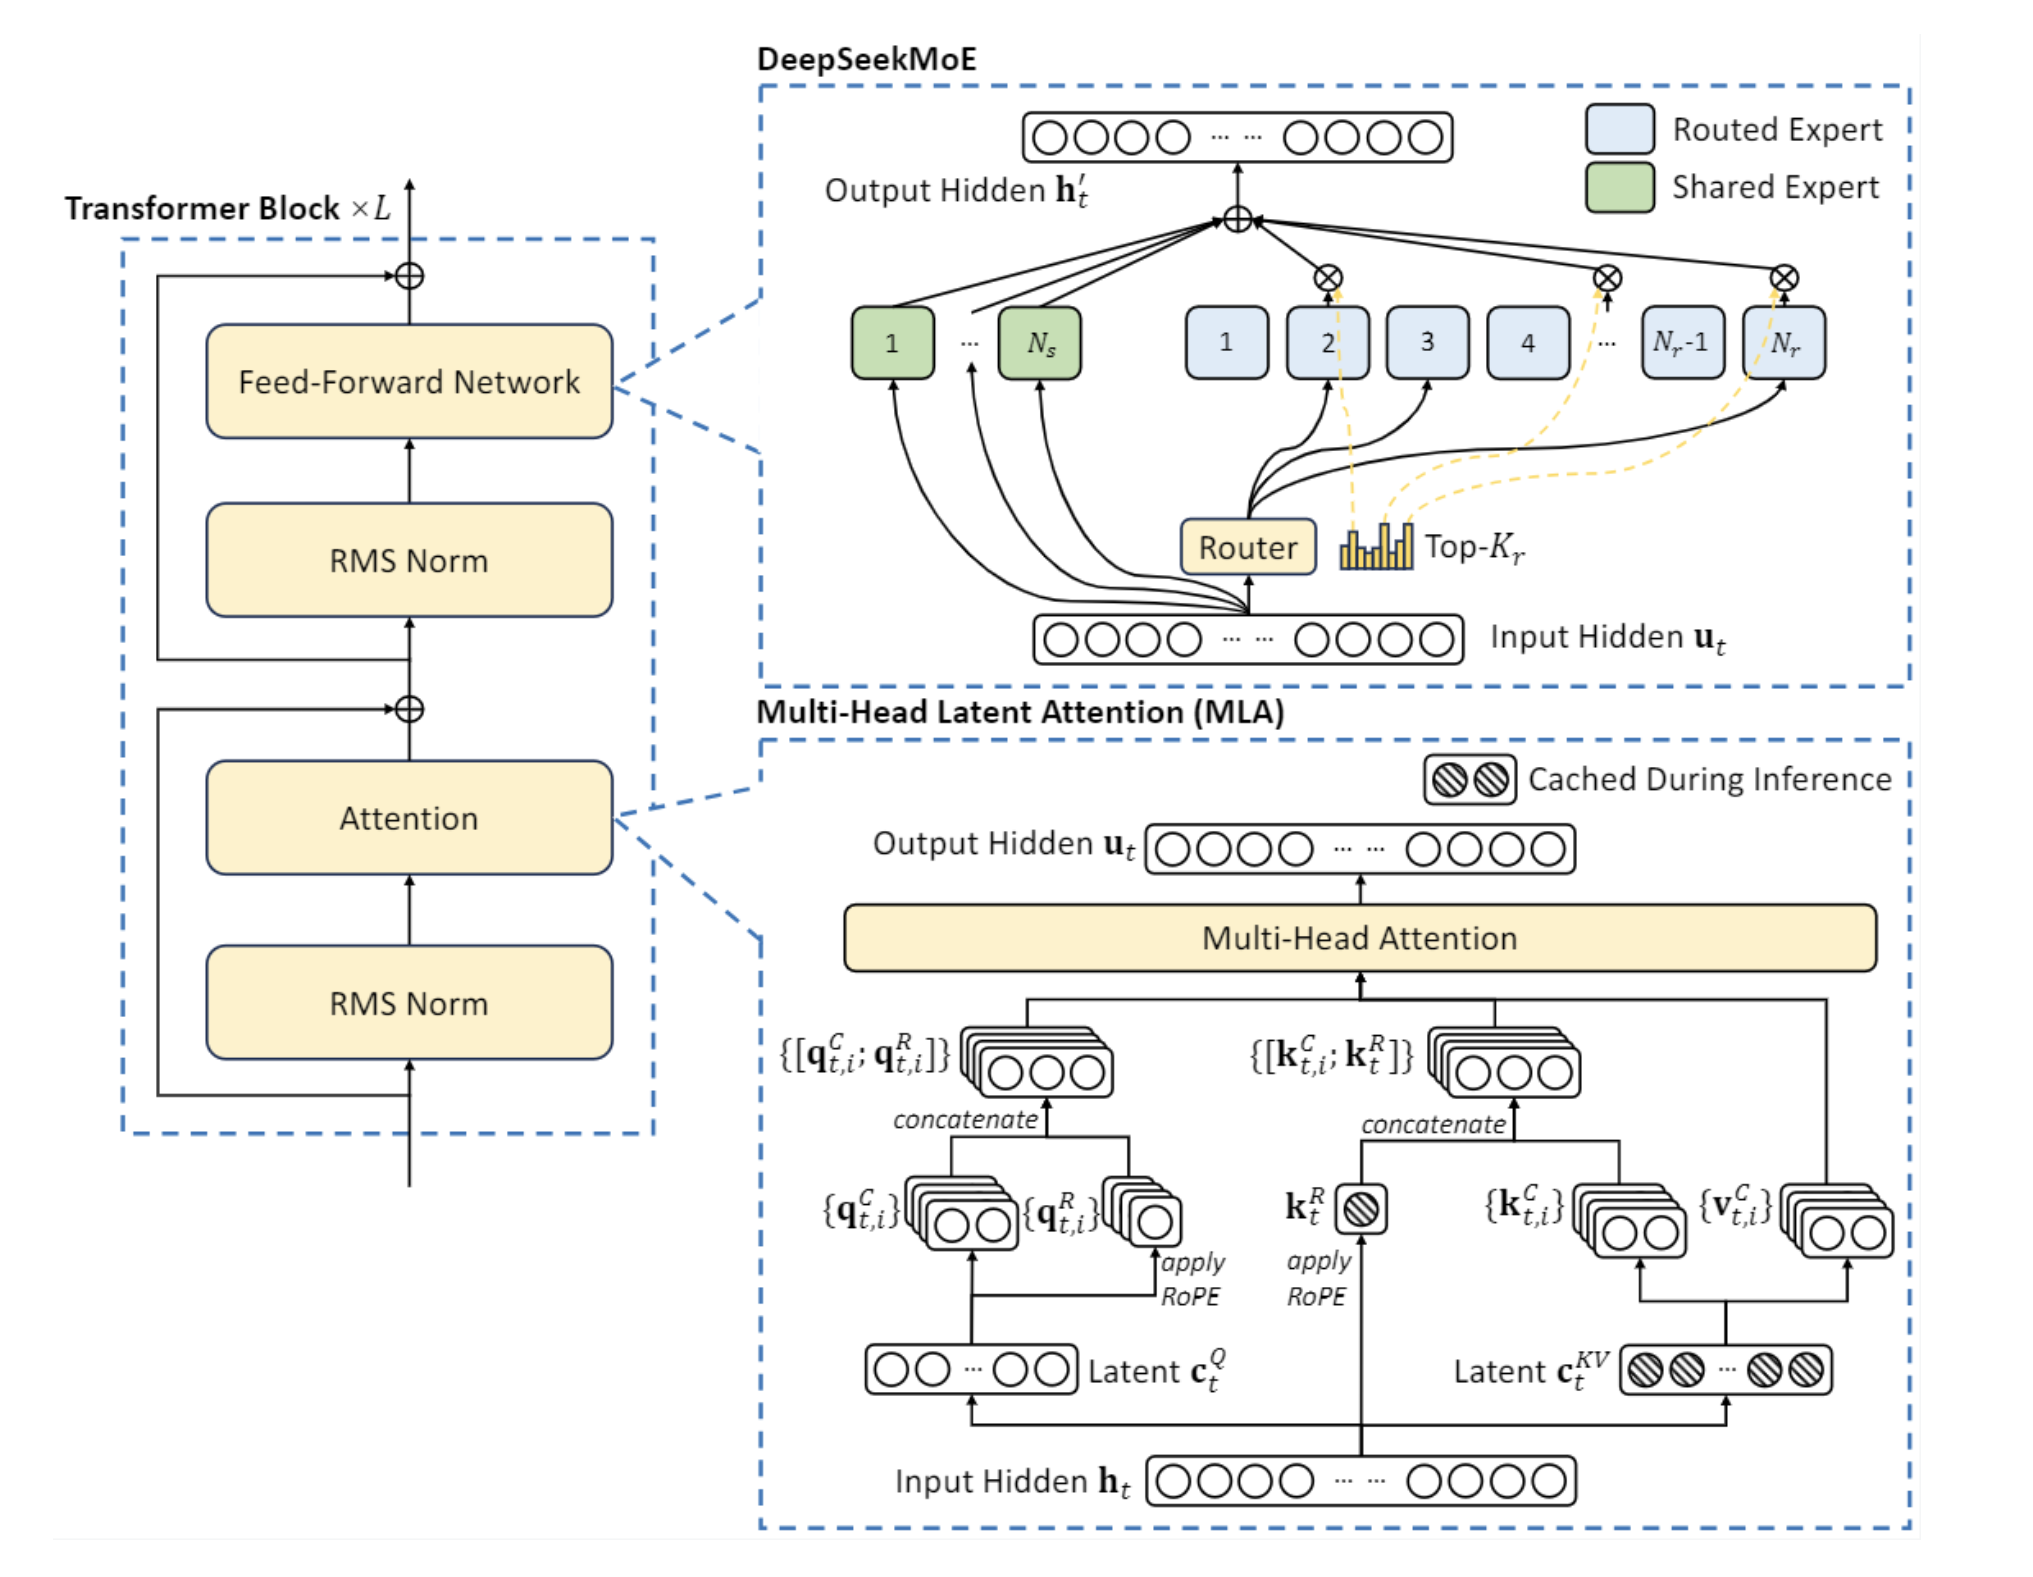

In [ ]:
class ShareExpertMoE(nn.Module):
    def __init__(self, config: MoEConfig):
        super().__init__()

        self.MoE_model = SparseMoE(config)

        # 只是增加了一组 (num_shared_experts) 共享专家
        self.shared_experts = nn.ModuleList(
            [
                SimpleExpert(
                    config.hidden_dim, config.hidden_dim
                ) for _ in range(config.num_shared_experts)
            ]
        )

    def forward(self, x):
        # x shape 是 (b, s, hidden_dim)
        # SparseMoE 网络
        sparse_MoE_out, router_logits = self.MoE_model(x) # (bs, seq, hidden_dim), (bs*seq, num_experts)
        
        shared_expert_outputs = torch.stack(
            [
                expert(x) for expert in self.shared_experts
            ],
            dim=0 # (num_shared_experts, bs, seq, hidden_dim)
        ).sum(0) # (bs, seq, hidden_dim)

        return sparse_MoE_out + shared_expert_outputs, router_logits


bs, seq, hidden_dim, num_experts = 2, 4, 16, 3
x = torch.rand(bs, seq, hidden_dim)
# 输出就应该是 (bs, seq, hidden_dim) 和 (bs*seq, num_experts)

config = MoEConfig(hidden_dim=hidden_dim, num_experts=num_experts, top_k=2)
share_expert_moe = ShareExpertMoE(config)
output = share_expert_moe(x)

print(output[0].shape, output[1].shape)


## MLA (Multi-Head Latent Attention) ##
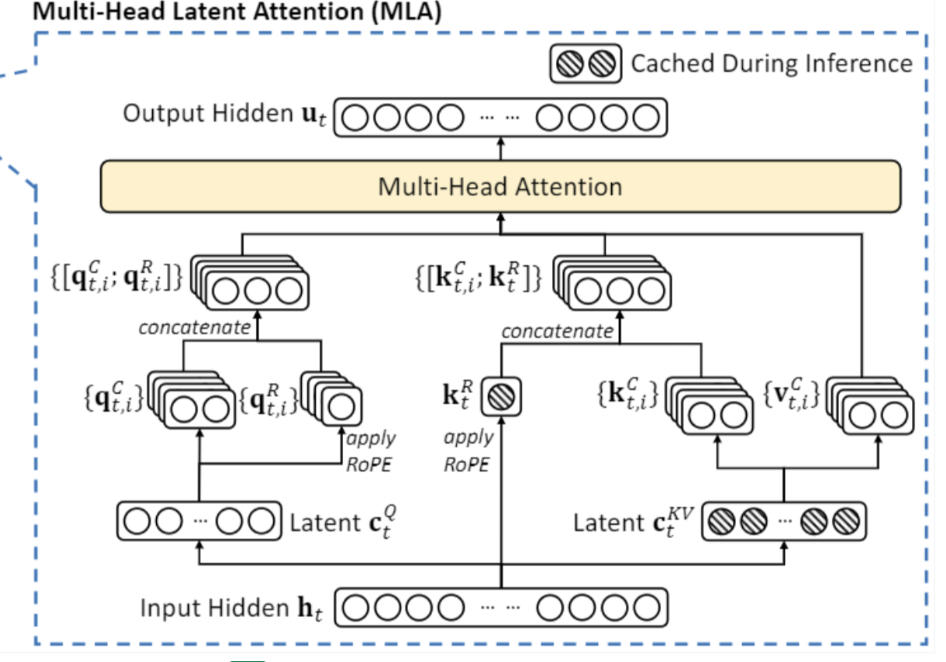
**Flow:**
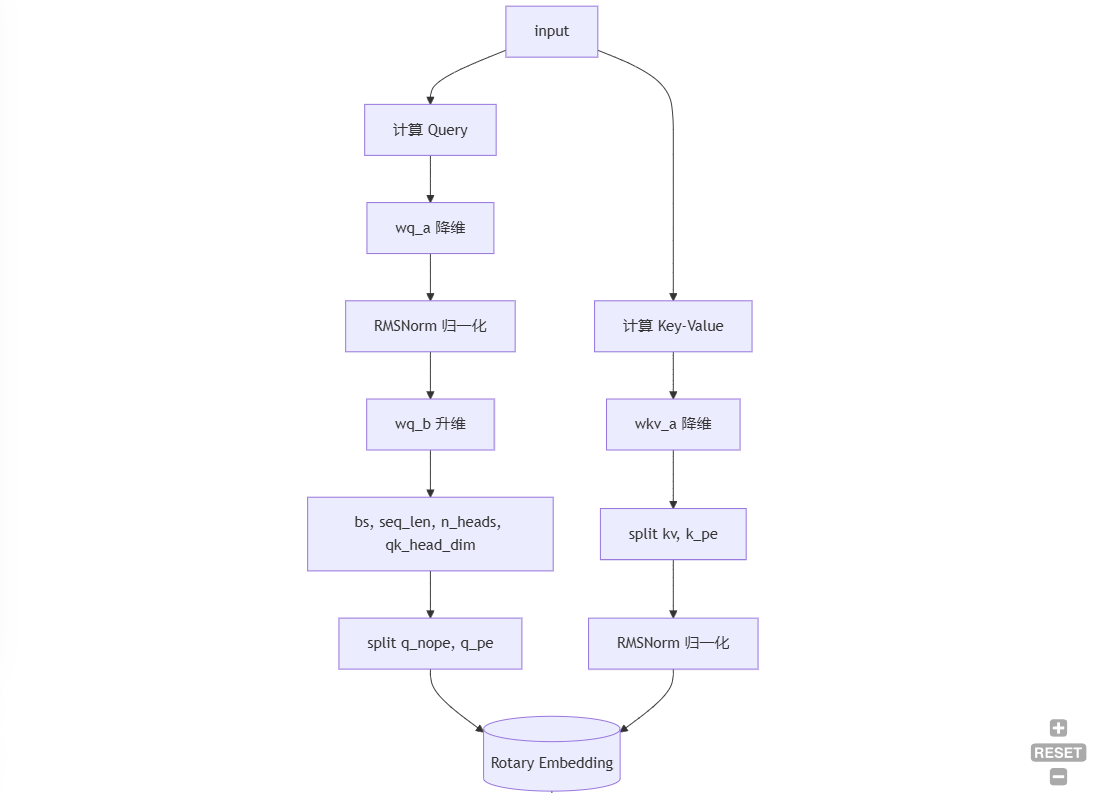
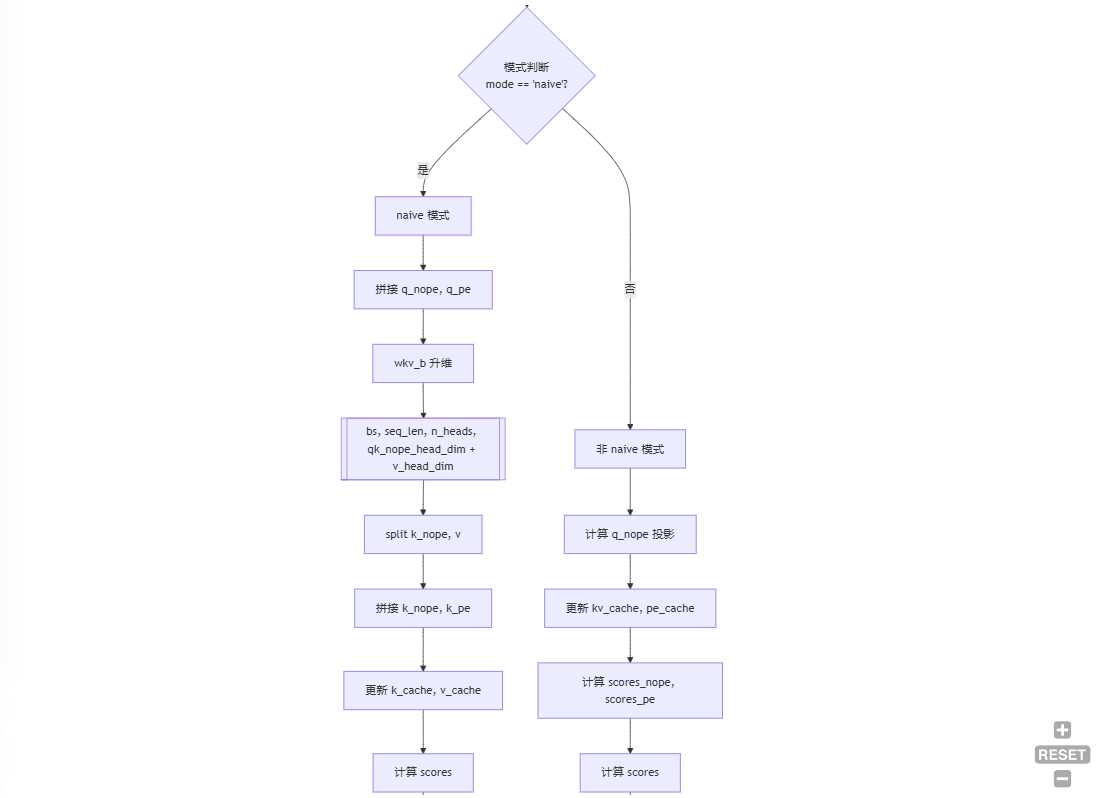
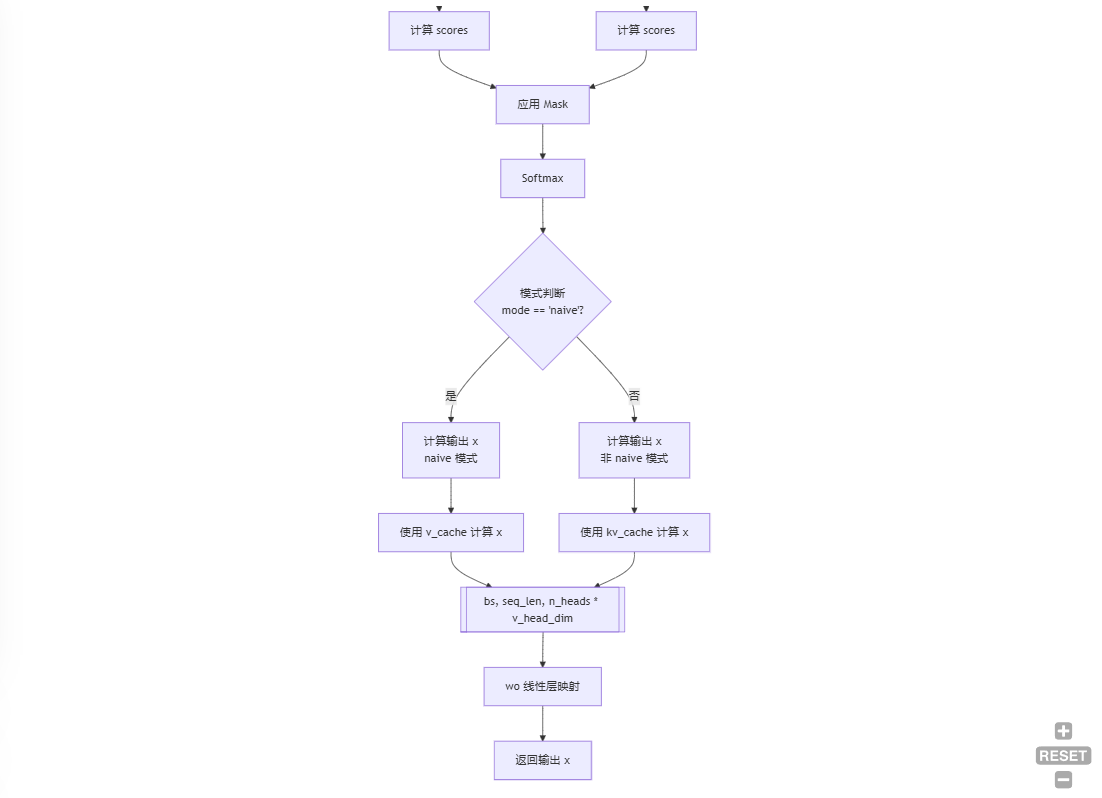

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# rmsnorm
class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        hidden_states = hidden_states.float()
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.float()

In [ ]:
def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotate_pos_emb(q, k, cos, sin, unsqueeze_dim=2):
    
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
   
    q_embed = (q*cos) + (rotate_half(q)*sin)
    k_embed = (k*cos) + (rotate_half(k)*sin)
    
    return q_embed, k_embed

# 旋转位置编码
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=1024):
        super(RotaryEmbedding, self).__init__()
        self.hidden_dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_seq_len).float().unsqueeze(1)
        freqs = t @ inv_freq.unsqueeze(0)
        freqs = torch.cat((freqs, freqs), dim=-1)
        
        self.register_buffer("cos_cached", freqs.cos())
        self.register_buffer("sin_cached", freqs.sin())
        
    def forward(self, q, k):
        cos = self.cos_cached[:q.shape[1], :].unsqueeze(0)
        sin = self.sin_cached[:q.shape[1], :].unsqueeze(0)
        return apply_rotate_pos_emb(q, k, cos, sin)    

In [ ]:
class MLAConfig:
    def __init__(
            self,
            hidden_dim, num_heads,
            q_lora_rank, kv_lora_rank,
            qk_nope_head_dim, qk_rope_head_dim,
            v_head_dim,
            max_seq_len, max_batch_size,
            mode
            ):
        self.hidden_dim = hidden_dim # 隐藏层维度
        self.num_heads = num_heads  #总头数
        self.q_lora_rank = q_lora_rank # q低秩压缩到的维度
        self.kv_lora_rank = kv_lora_rank # kv低秩压缩到的维度
        self.qk_nope_head_dim = qk_nope_head_dim
        self.qk_rope_head_dim = qk_rope_head_dim
        # self.qk_head_dim = qk_nope_head_dim + qk_rope_head_dim # qk的总维度，不带旋转位置编码的维度加上带旋转位置编码的维度
        self.v_head_dim = v_head_dim # value的维度，等于不带旋转位置编码的k维度
        self.max_seq_len = max_seq_len
        self.max_batch_size = max_batch_size
        self.mode = mode



class MLA(nn.Module):
    def __init__(self, config: MLAConfig):
        super().__init__()
        self.config = config
        self.hidden_dim = config.hidden_dim # 隐藏层维度
        self.num_heads = config.num_heads  #总头数
        self.q_lora_rank = config.q_lora_rank # q低秩压缩到的维度
        self.kv_lora_rank = config.kv_lora_rank # kv低秩压缩到的维度
        self.qk_nope_head_dim = config.qk_nope_head_dim
        self.qk_rope_head_dim = config.qk_rope_head_dim
        self.qk_head_dim = self.qk_nope_head_dim + self.qk_rope_head_dim # qk的总维度，不带旋转位置编码的维度加上带旋转位置编码的维度
        self.v_head_dim = config.v_head_dim # value的维度，等于不带旋转位置编码的k维度
        self.max_seq_len = config.max_seq_len
        self.max_batch_size = config.max_batch_size
        self.mode = config.mode
        
        
        self.wq_a = nn.Linear(self.hidden_dim, self.q_lora_rank) # q的降维矩阵
        self.q_norm = RMSNorm(self.q_lora_rank)
        self.wq_b = nn.Linear(self.q_lora_rank, self.num_heads * self.qk_head_dim) # q的升维矩阵
        # 4096*128+128*4864 = 524,288 + 622592 = 1146880    4096*4864 = 19,922,944
        
        self.wkv_a = nn.Linear(self.hidden_dim, self.kv_lora_rank + self.qk_rope_head_dim) # kv的降维矩阵
        # nn.Linear(self.hidden_dim, self.kv_lora_rank)
        # nn.Linear(self.hidden_dim, self.qk_rope_head_dim)
        self.kv_norm = RMSNorm(self.kv_lora_rank)
        self.wkv_b = nn.Linear(self.kv_lora_rank, self.num_heads * (self.qk_nope_head_dim + self.v_head_dim)) # kv的升维矩阵
        
        self.wo = nn.Linear(self.num_heads * self.v_head_dim, self.hidden_dim)
        
        self.rotary_emb = RotaryEmbedding(self.qk_rope_head_dim) # 旋转旋转位置编码
        
        if self.mode == 'naive':
            self.register_buffer('k_cache', torch.zeros(self.max_batch_size, self.max_seq_len, self.num_heads, self.qk_head_dim), persistent=False)
            self.register_buffer('v_cache', torch.zeros(self.max_batch_size, self.max_seq_len, self.num_heads, self.v_head_dim), persistent=False)
            
        else:
            self.register_buffer('kv_cache', torch.zeros(self.max_batch_size, self.max_seq_len, self.kv_lora_rank), persistent=False)
            self.register_buffer('pe_cache', torch.zeros(self.max_batch_size, self.max_seq_len, self.qk_rope_head_dim), persistent=False)
            
        
    def forward(self, x, mask=None):
        
        bs, seq_len, _ = x.shape
        
        q = self.wq_a(x)  # [bs, seq_len, q_lora_rank]
        q = self.q_norm(q) # [bs, seq_len, q_lora_rank]
        q = self.wq_b(q) # [bs, seq_len, n_heads * qk_head_dim]
        q = q.view(bs, seq_len, self.num_heads, self.qk_head_dim) # [bs, seq_len, n_heads, qk_head_dim]
        q_nope, q_pe = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1) # q_nope shape:[bs, seq_len, n_heads, qk_nope_head_dim] q_pe shape:[bs, seq_len, n_heads, qk_rope_head_dim]
        
        kv = self.wkv_a(x) # [bs, seq_len, kv_lora_rank + qk_rope_head_dim]
        kv, k_pe = torch.split(kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1) # kv shape:[bs, seq_len, kv_lora_rank] k_pe shape:[bs, seq_len, qk_rope_head_dim]
        
        k_pe = k_pe.unsqueeze(2) # k_pe shape:[bs, seq_len, 1, qk_rope_head_dim]
        q_pe, k_pe = self.rotary_emb(q_pe, k_pe)
        if self.mode == 'naive':
            
            q = torch.cat([q_nope, q_pe], dim=-1) # * [bs, seq_len, n_heads, qk_head_dim]
            
            kv = self.kv_norm(kv) # [bs, seq_len, kv_lora_rank)]
            kv = self.wkv_b(kv) # [bs, seq_len, n_heads * (qk_nope_head_dim + v_head_dim)]
            kv = kv.view(bs, seq_len, self.num_heads, self.qk_nope_head_dim + self.v_head_dim)
            k_nope, v = torch.split(kv, [self.qk_nope_head_dim, self.v_head_dim], dim=-1)
            
            k = torch.cat([k_nope, k_pe.expand(-1,-1,self.num_heads,-1)], dim=-1) 
            # k shape:[bs, seq_len, n_heads, qk_head_dim]
            self.k_cache[:bs, :seq_len, :, :] = k
            self.v_cache[:bs, :seq_len, :, :] = v
            # scores = torch.einsum("bshd,bthd->bsht", q, self.k_cache[:bs, :seq_len]) / math.sqrt(self.qk_nope_head_dim + self.qk_rope_head_dim)
            scores = torch.matmul(q.transpose(1, 2), self.k_cache[:bs, :seq_len, :, :].transpose(1, 2).transpose(2, 3) / math.sqrt(self.qk_nope_head_dim + self.qk_rope_head_dim))
            scores = scores.transpose(1, 2)
            
        else:
            k_pe = k_pe.squeeze(2)
            wkv_b = self.wkv_b.weight  # [n_heads * (qk_nope_head_dim + v_head_dim), kv_lora_rank]
            wkv_b = wkv_b.view(self.num_heads, -1, self.kv_lora_rank) # [n_heads, qk_nope_head_dim + v_head_dim, kv_lora_rank]
            q_nope = torch.einsum("bshd,hdc->bshc", q_nope, wkv_b[:, :self.qk_nope_head_dim]) # q_nope shape:[bs, seq_len, n_heads, kv_lora_rank]
            # q*k(T) = x*wq*(c*wkv_b[:, :self.qk_nope_head_dim])(T) = x*wq*wkv_b[:, :self.qk_nope_head_dim](T)*c(T)    c为压缩后的kv
            # wq*wkv_b[:, :self.qk_nope_head_dim](T)作为q的投影矩阵  c可以替代原先的k，这样就可以直接使用压缩后的kv计算注意力了，kv_caceh时也只需存储压缩后的kv
            kv = self.kv_norm(kv)
            self.kv_cache[:bs, :seq_len, :] = kv # kv shape:[bs, seq_len, kv_lora_rank]
            self.pe_cache[:bs, :seq_len, :] = k_pe # k_pe shape:[bs, seq_len, qk_rope_head_dim]
            
            scores_nope = torch.einsum("bshc,btc->bsht", q_nope, self.kv_cache[:bs, :seq_len, :]) # bshc btc -> bshc bct -> bsht
            scores_pe = torch.einsum("bshr,btr->bsht", q_pe, self.pe_cache[:bs, :seq_len, :])  # bshr btr -> bshr bt1r -> bshr bthr -> bsht
            scores = (scores_nope + scores_pe) / math.sqrt(self.qk_nope_head_dim + self.qk_rope_head_dim) # [bs, seq_len, n_heads, seq_len]
        
        if mask is not None:
            # mask shape:[bs, seq_len, seq_len]
            scores += mask.unsqueeze(2)
        
        scores = scores.softmax(dim=-1)

        if self.mode == 'naive':
            x = torch.einsum("bsht,bthd->bshd", scores, self.v_cache[:bs, :seq_len]) # bsht,bthd -> bhst, bhtd -> bhsd -> bshd
        else:
            
            # scores * v = scores * c * wkv_b[:, -self.v_head_dim:]
            x = torch.einsum("bsht,btc->bshc", scores, self.kv_cache[:bs, :seq_len]) # x shape:[bs, seq_len, n_heads, kv_lora_rank]
            x = torch.einsum("bshc,hdc->bshd", x, wkv_b[:, -self.v_head_dim:]) # bshc, hdc -> bshc,dch -> bsdh -> bshd
    
        x = x.contiguous ().view(bs, seq_len, -1)
        x = self.wo(x)
        
        return x

In [ ]:
x = torch.randn(4, 100, 4096)

hidden_dim = 4096
num_heads = 16
q_lora_rank = 128
kv_lora_rank = 64
qk_nope_head_dim = 256
qk_rope_head_dim = 48
v_head_dim = 256
max_seq_len = 512
max_batch_size = 16
mode = 'none'

mla_config = MLAConfig(
        hidden_dim=hidden_dim,
        num_heads=num_heads, 
        q_lora_rank=q_lora_rank, 
        kv_lora_rank=kv_lora_rank, 
        qk_nope_head_dim=qk_nope_head_dim, 
        qk_rope_head_dim=qk_rope_head_dim, 
        v_head_dim=v_head_dim, 
        max_seq_len=max_seq_len, 
        max_batch_size=max_batch_size, 
        mode=mode
)

mla = MLA(mla_config)
print(mla)

print(mla(x))
print(mla.kv_cache)

## Decoder Layer ##

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, config, layer_idx):
        super().__init__()
        self.hidden_size = config.hidden_dim
        self.attn = MLA(config)
        self.moe = ShareExpertMoE(config)
        self.input_layernorm = RMSNorm(config.hidden_dim)
        self.pos_attn_layernorm = RMSNorm(config.hidden_dim)
        self.layer_idx = layer_idx

    def forward(self, hidden_states, use_kv_cache):
        residual = hidden_states
        hidden_states = self.input_layernorm(hidden_states)

        hidden_states = self.attn(hidden_states)

x = torch.randn(4, 100, 4096)
attention_mask = torch.ones(4, 100, 100)


## Training ##

常规: pretrain -> sft -> rl

Zero: pretrain -> rl

R1: pretrain -> sft一阶段 -> rl一阶段 -> sft二阶段 -> rl二阶段

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset, Dataset
import torch
import os
import trl
from trl import PPOConfig, PPOTrainer
# from trl import GRPOConfig, GRPOTrainer
# GRPOTrainer 需要 vllm -> 需要 unix-only 的 resource 库

e:\Production\Programing\Env\anaconda3_2022.10\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# jupyter kernelspec list
# %env HF_HOME=E:\Production\models\hgf

print(torch.cuda.is_available())

model_path = "Qwen/Qwen2.5-0.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
model.cuda()
tokenizer = AutoTokenizer.from_pretrained(model_path)


True


In [11]:
raw_data = load_dataset('swulling/gsm8k_chinese')
print(raw_data.column_names)

# 处理数据, 重新映射
def process_data(data):
    # 将数据中的每个元素映射为一个字典，字典中包含两个键值对，一个是prompt，一个是answer
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question_zh-cn']}
        ],
        'answer': x['answer_only']
    }) 
    # 返回处理后的数据
    return data

SYSTEM_PROMPT = """
按照如下格式生成回答：
<think>
...
</think>
<answer>
...
</answer>
"""
data = process_data(raw_data['train'])
print(data.column_names)


{'test': ['question', 'answer', 'question_zh-cn', 'answer_only'], 'train': ['question', 'answer', 'question_zh-cn', 'answer_only']}
['question', 'answer', 'question_zh-cn', 'answer_only', 'prompt']


### 奖励机制 ###

In [ ]:
import re

# 回答提取
def extract_answer(text):
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

# 格式奖励 1
def mark_num(text):
    reward = 0
    if text.count("<think>\n") == 1:
        reward += 0.125
        
    if text.count("</think>\n") == 1:
        reward += 0.125
        
    if text.count("<answer>\n") == 1:
        reward += 0.125
        
    if text.count("</answer>\n") == 1:
        reward += 0.125
    return reward

# 生成答案是否正确的奖励
def correctness_reward(prompts, completions, answer, **kwargs):
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_answer(r) for r in responses]
    print(f"问题:\n{prompts[0][-1]['content']}", f"\n答案:\n{answer[0]}", f"\n模型输出:\n{responses[0]}", f"\n提取后的答案:\n{extracted_responses[0]}")
    return [2.0 if response == str(ans) else 0.0 for response, ans in zip(extracted_responses, answer)]

# 生成答案是否是数字的奖励（单纯依赖结果是否正确进行奖励，条件很苛刻，会导致奖励比较稀疏，模型难以收敛，所以加上答案是否是数字的奖励，虽然答案错误，但是至少生成的是数字（对于数学问题），也要给予适当奖励）
def digit_reward(completions, **kwargs):
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_answer(r) for r in responses]
    return [0.5 if response.isdigit() else 0.0 for response in extracted_responses]

# 格式奖励 2
def hard_format_reward(completions, **kwargs):
    pattern = r"^<think>\n\.*?n</think>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, response) for response in responses]
    return [0.5 if match else 0.0 for match in matches]

# 格式奖励 3
def soft_format_reward(completions, **kwargs):
    pattern = r"<think>.*?</think>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, response) for response in responses]
    return [0.5 if match else 0.0 for match in matches]

# 标记奖励（改善格式奖励稀疏问题）
def mark_reward(completions, **kwargs):
    responses = [completion[0]["content"] for completion in completions]
    return [mark_num(response) for response in responses]